# Computer Vision, Dr. Aygul Zagidullina, Dr. Dimitris Mousadakos

# Transfer Learning Exercise

*  Tech companies and university labs have more computational resources than we do
*  Let them train their very complex models on millions of images, and then re-use their kernels for our own CNNs!

🎯 **<u>Goal:</u>**
* ☄️ Use a **Pretrained Neural Network** $ \Leftrightarrow $ **Transfer learning**

## Google Colab Setup

Repeat the same process from the last example to upload and open your notebook:

1. access your [Google Drive](https://drive.google.com/)
2. go into the Colab Notebooks folder
3. drag and drop this notebook into it
4. right-click the notebook file and select `Open with` $\rightarrow$ `Google Colaboratory`

Don't forget to enable GPU acceleration!

`Runtime` $\rightarrow$ `Change runtime type` $\rightarrow$ `Hardware accelerator` $\rightarrow$ `GPU`

When this is done, run the cells below and get to work!

## (1) What is a Pre-Trained Neural Network?

* Convolutions are mathematical operations designed to detect specific patterns in input images and use them to classify the images.
* One could imagine that these patterns are not 100% specific to one task but to the input images.

🚀 **Why not re-use these kernels - whose weights have already been optimized - somewhere else?**
- The expectation is that the trained kernels could also help us perform another classification task.
- We are trying to ***transfer*** the knowledge of a trained CNN to a new classification task.


💪 Transfer Learning has two main advantages:
- It takes less time to train a pre-trained model since we are not going to update all the weights but only some of them
- You benefit from state-of-the-art architectures that have been trained on complex images.

## (2) Introduction to  VGG16

📚 ***Reading Section, no code***






In this exercise, we will use the <a href="https://neurohive.io/en/popular-networks/vgg16/">**`VGG-16 Neural Network`**</a>.

> VGG16 is a convolutional neural network model proposed by K. Simonyan and A. Zisserman from the University of Oxford in the paper “Very Deep Convolutional Networks for Large-Scale Image Recognition”. The model achieves 92.7% top-5 test accuracy in ImageNet, which is a dataset of over 14 million images belonging to 1000 classes. It was one of the famous model submitted to ILSVRC-2014. It makes the improvement over AlexNet by replacing large kernel-sized filters (11 and 5 in the first and second convolutional layer, respectively) with multiple 3×3 kernel-sized filters one after another. VGG16 was trained for weeks and was using NVIDIA Titan Black GPU’s.

VGG16 is a well-known architecture that has been trained on the <a href="https://www.image-net.org/">**`ImageNet dataset`**</a> which is a very large database of images which belong to different categories.

👉 This architecture already learned which kernels are the best for extracting features from the images found in the `ImageNet dataset`.

👉 As we can see in the illustration, the VGG16 involves millions of parameters we don't want to retrain ourself.


<center><img src="https://neurohive.io/wp-content/uploads/2018/11/vgg16-1-e1542731207177.png" width=400></center>

❓ How does it work in practice ❓

* The first layers are not specialized for the particular task the VGG16 CNN was trained on
* Only the last dense layer is a "classification layers" that can be preceded with a couple of dense layers...  Therefore, we will:
    1. Load the existing VGG16 network
    2. Remove the last fully connected layers
    3. Replace them with some new fully-connected layers (whose weights are randomly set)
    4. Train these last layers on a specific classification task.

😃 Our role is to train only the last layers for our particular problem.


In [1]:
# ==========================================
# 1. IMPORTS & SETUP
# ==========================================
import copy
from sklearn.metrics import classification_report
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import torch
import os
from PIL import Image
from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
import torch.nn as nn

# Set device configuration
# Select the device (GPU or CPU)
if torch.backends.mps.is_available():
    device = "mps"
    print(f"✅ Device set to Apple Silicon GPU (MPS)")
elif torch.cuda.is_available():
    device = "cuda"
    print(f"✅ Device set to NVIDIA GPU (CUDA)")
else:
    device = "cpu"
    print(f"✅ Device set to CPU")

✅ Device set to Apple Silicon GPU (MPS)


In [2]:
# ==========================================
# 2. FUNCTIONS
# ==========================================

def load_flowers_data(img_size=(224, 224)):
    """
    Loads flower dataset, resizes, and splits into Train (60%), Val (20%), Test (20%).
    """
    if not os.path.exists('flowers'):
        print("Downloading dataset...")
        !wget -q https://drive.google.com/uc?export=download&id=1aIHzXwYBCIeQeG0cD3KBSE_BXlYrmO6I -O flowers-dataset.zip
        !unzip -q -n flowers-dataset.zip
    
    data_path = 'flowers/'
    classes = {'daisy': 0, 'dandelion': 1, 'rose': 2}
    imgs = []
    labels = []

    print("Loading images...")
    for (cl, i) in classes.items():
        class_dir = os.path.join(data_path, cl)
        image_files = [f for f in os.listdir(class_dir) if f.endswith('.jpg')]
        for img_name in tqdm(image_files[:300], desc=f"Loading {cl}"): 
            img_path = os.path.join(class_dir, img_name)
            try:
                image = Image.open(img_path).convert('RGB')
                image = image.resize(img_size)
                imgs.append(np.array(image))
                labels.append(i)
            except Exception as e:
                print(f"Error loading {img_path}: {e}")

    X = np.array(imgs)
    y = np.array(labels)

    # Shuffle
    p = np.random.permutation(len(X))
    X, y = X[p], y[p]

    # Split: 20% Test, 20% Val, 60% Train
    total = len(X)
    n_test = int(total * 0.2)
    n_val = int(total * 0.2)
    n_train = total - n_test - n_val

    X_test, y_test = X[:n_test], y[:n_test]
    X_val, y_val = X[n_test:n_test+n_val], y[n_test:n_test+n_val]
    X_train, y_train = X[n_test+n_val:], y[n_test+n_val:]

    print(f"Data Split -> Train: {X_train.shape[0]}, Val: {X_val.shape[0]}, Test: {X_test.shape[0]}")
    
    def to_tensor(x):
        return torch.from_numpy(x).permute(0, 3, 1, 2)
    
    return to_tensor(X_train), torch.from_numpy(y_train).long(), \
           to_tensor(X_val), torch.from_numpy(y_val).long(), \
           to_tensor(X_test), torch.from_numpy(y_test).long(), \
           len(classes)

class FlowerTensorDataset(Dataset):
    """
    Custom Dataset to handle Tensor data and apply transforms.
    """
    def __init__(self, x_tensor, y_tensor, transform=None):
        self.x = x_tensor
        self.y = y_tensor
        self.transform = transform

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        # x is (C, H, W). ToPILImage requires (C, H, W) or (H, W, C)
        image = self.x[idx]
        label = self.y[idx]
        
        # If we have transforms, we often need a PIL image or 0-1 float tensor
        if self.transform:
            # Convert uint8 tensor to PIL for torchvision transforms
            image = transforms.ToPILImage()(image) 
            image = self.transform(image)
        else:
            # Default scaling if no transform provided
            image = image.float() / 255.0
            
        return image, label

class EarlyStopping:
    """
    Early stops the training if validation loss doesn't improve after a given patience.
    """
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0


def train_network(model, train_loader, val_loader, criterion, optimizer, num_epochs=20, patience=5):
    """
    Training loop with Early Stopping and ReduceLROnPlateau Scheduler.
    """
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    # 1. Setup Early Stopping
    early_stopper = EarlyStopping(patience=patience)
    
    # 2. Setup LR Scheduler
    # Reduces LR by factor of 0.1 if val_loss doesn't improve for 2 epochs
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')
    
    print(f"Starting training on {device}...")

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = correct / total
        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc)
        
        # Validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        val_epoch_loss = val_loss / len(val_loader)
        val_epoch_acc = val_correct / val_total
        history['val_loss'].append(val_epoch_loss)
        history['val_acc'].append(val_epoch_acc)
        
        # Print stats including current Learning Rate
        current_lr = optimizer.param_groups[0]['lr']
        print(f'Epoch [{epoch+1}/{num_epochs}] LR: {current_lr:.1e} | '
              f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} | '
              f'Val Loss: {val_epoch_loss:.4f} Acc: {val_epoch_acc:.4f}')

        # 3. Step Scheduler
        scheduler.step(val_epoch_loss)

        if val_epoch_loss < best_loss:
            best_loss = val_epoch_loss
            best_model_wts = copy.deepcopy(model.state_dict())

        # 4. Check Early Stopping
        early_stopper(val_epoch_loss)
        if early_stopper.early_stop:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break
            
    print(f"Restoring best weights with Val Loss: {best_loss:.4f}")
    model.load_state_dict(best_model_wts)
    return history

def plot_performance(history):
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Acc')
    plt.plot(history['val_acc'], label='Val Acc')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.show()

def evaluate_network(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    acc = 100 * correct / total
    print(f"\n=== Final Test Set Evaluation ===")
    print(f"Test Accuracy: {acc:.2f}%")
    print("-" * 30)
    print("Classification Report:")
    print(classification_report(all_labels, all_preds))
    return acc


--- 3. Training Simple Network ---
Loading images...


Loading rose: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 299/299 [00:00<00:00, 553.91it/s]


Data Split -> Train: 541, Val: 179, Test: 179
Starting training on mps...
Epoch [1/20] LR: 1.0e-03 | Train Loss: 1.1178 Acc: 0.4344 | Val Loss: 0.9739 Acc: 0.4860
Epoch [2/20] LR: 1.0e-03 | Train Loss: 0.8971 Acc: 0.6100 | Val Loss: 1.0654 Acc: 0.4804
Epoch [3/20] LR: 1.0e-03 | Train Loss: 0.8488 Acc: 0.6192 | Val Loss: 0.7913 Acc: 0.6536
Epoch [4/20] LR: 1.0e-03 | Train Loss: 0.7673 Acc: 0.6506 | Val Loss: 0.7780 Acc: 0.6927
Epoch [5/20] LR: 1.0e-03 | Train Loss: 0.6681 Acc: 0.7153 | Val Loss: 0.7177 Acc: 0.6983
Epoch [6/20] LR: 1.0e-03 | Train Loss: 0.6326 Acc: 0.7190 | Val Loss: 0.7173 Acc: 0.6704
Epoch [7/20] LR: 1.0e-03 | Train Loss: 0.5106 Acc: 0.7948 | Val Loss: 0.7264 Acc: 0.7263
Epoch [8/20] LR: 1.0e-03 | Train Loss: 0.4295 Acc: 0.8373 | Val Loss: 0.7507 Acc: 0.6872
Epoch [9/20] LR: 1.0e-03 | Train Loss: 0.3694 Acc: 0.8447 | Val Loss: 0.8080 Acc: 0.7039
Epoch [10/20] LR: 1.0e-04 | Train Loss: 0.2933 Acc: 0.8909 | Val Loss: 0.7097 Acc: 0.7207
Epoch [11/20] LR: 1.0e-04 | Train L

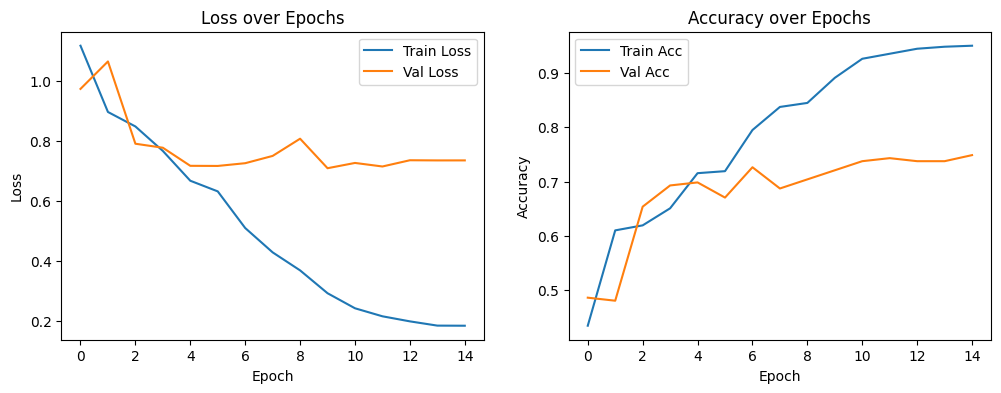


=== Final Test Set Evaluation ===
Test Accuracy: 70.95%
------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.77      0.73        64
           1       0.65      0.58      0.61        59
           2       0.77      0.79      0.78        56

    accuracy                           0.71       179
   macro avg       0.71      0.71      0.71       179
weighted avg       0.71      0.71      0.71       179



70.94972067039106

In [3]:
# ==========================================
# 3. SIMPLE NETWORK
# ==========================================
print("\n--- 3. Training Simple Network ---")

# 1. Load Data
X_train, y_train, X_val, y_val, X_test, y_test, num_classes = load_flowers_data(img_size=(224, 224))

# 2. Create Datasets
batch_size = 32
train_ds = FlowerTensorDataset(X_train, y_train, transform=transforms.ToTensor())
val_ds = FlowerTensorDataset(X_val, y_val, transform=transforms.ToTensor())
test_ds = FlowerTensorDataset(X_test, y_test, transform=transforms.ToTensor())

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size)
test_loader = DataLoader(test_ds, batch_size=batch_size)

# 3. Define Model
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )
    def forward(self, x):
        return self.classifier(self.features(x))

model_simple = SimpleCNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_simple.parameters(), lr=0.001)

# 4. Train
# (Scheduler is active: LR will reduce if Val Loss stagnates for 2 epochs)
history_simple = train_network(model_simple, train_loader, val_loader, criterion, optimizer, num_epochs=20, patience=5)

# 5. Plot & Test
plot_performance(history_simple)
evaluate_network(model_simple, test_loader)

## Using a pre-trained CNN = Transfer learning

As it's said in the beginning, tech companies and university labs have more computational resources than we do.

🔥 The [**Visual Geometry Group**](https://www.robots.ox.ac.uk/~vgg/data/) *(Oxford University, Department of Science and Engineering)* became famous for some of their **Very Deep Convolutional Neural Networks**: the [**VGG16**](https://www.robots.ox.ac.uk/~vgg/research/very_deep/)

<center><img src="https://neurohive.io/wp-content/uploads/2018/11/vgg16-1-e1542731207177.png" width=400></center>

Take 7 minutes of your time to watch this incredible video of Convolutional Layers created by Dimitri Dmitriev.

* 📺 **[VGG16 Neural Network Visualization](https://www.youtube.com/watch?v=RNnKtNrsrmg)**


### (5.1) Load VGG16 model

❓ **Question: loading the VGG16** ❓

* Write a first function `load_model()` that loads the pretrained VGG-16 model from `torchvision.models`. Have a look at the documentation 📚  [tf/keras/applications/VGG16](https://www.tensorflow.org/api_docs/python/tf/keras/applications/VGG16)📚

* We will **load the VGG16 model** the following way:
    - Let's use the **weights** learned on the [**imagenet dataset**](https://www.image-net.org/download.php) (14M pictures with 20k labels)
          
PyTorch models like VGG16 are typically built using `nn.Sequential` blocks for different parts of the network. For VGG16, the model is split into two main attributes:

* **`.features`**: This contains all the convolutional and pooling layers, responsible for extracting features from the image. This is the direct equivalent of the Keras model with `include_top=False`.
* **`.classifier`**: This contains the final fully connected (dense) layers that perform the classification based on the extracted features.

By loading the full model and then selecting `vgg_full_model.features`, you get exactly what you need for transfer learning.

<i><u>Remark:</u></i> Do not change the default value of the other arguments

In PyTorch's `torchvision` library, we achieve this by loading the complete model and then selecting its feature extraction part, which is conveniently separated.


--- 4. Transfer Learning with VGG16 (Frozen Features) ---

Visualizing first layer filters (kernels)...


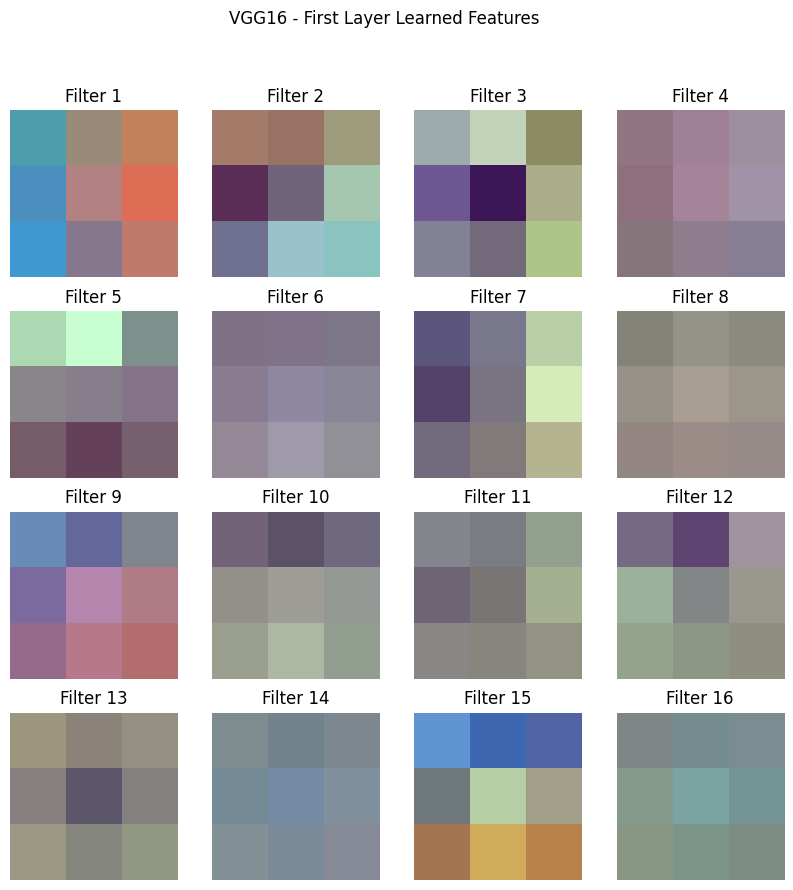


[Detailed Summary Table]
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             

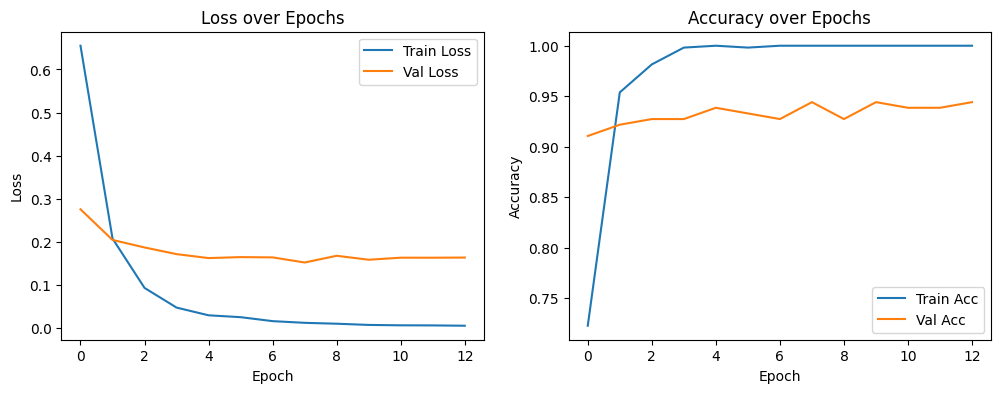


=== Final Test Set Evaluation ===
Test Accuracy: 90.50%
------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.88      0.90        64
           1       0.88      0.88      0.88        59
           2       0.92      0.96      0.94        56

    accuracy                           0.91       179
   macro avg       0.90      0.91      0.91       179
weighted avg       0.91      0.91      0.90       179



90.50279329608938

In [4]:
# ==========================================
# 4. TRANSFER LEARNING (VGG16)
# ==========================================
print("\n--- 4. Transfer Learning with VGG16 (Frozen Features) ---")

try:
    from torchsummary import summary
except ImportError:
    !pip install torchsummary --quiet
    from torchsummary import summary

# 1. Load Pretrained Weights
vgg_weights = models.VGG16_Weights.IMAGENET1K_V1
vgg_model = models.vgg16(weights=vgg_weights)

# 2. Freeze Features
for param in vgg_model.features.parameters():
    param.requires_grad = False

# 3. Custom Classifier
num_features = vgg_model.classifier[0].in_features
vgg_model.classifier = nn.Sequential(
    nn.Flatten(),
    nn.Linear(num_features, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, num_classes)
)

# --- VISUALIZE FEATURES (Do this on CPU before moving to device) ---
def visualize_first_layer_filters(model):
    print("\nVisualizing first layer filters (kernels)...")
    filters = model.features[0].weight.data.cpu()
    filters = filters - filters.min()
    filters = filters / filters.max()
    
    plt.figure(figsize=(10, 10))
    for i in range(16):
        plt.subplot(4, 4, i+1)
        plt.imshow(filters[i].permute(1, 2, 0))
        plt.axis('off')
        plt.title(f'Filter {i+1}')
    plt.suptitle("VGG16 - First Layer Learned Features")
    plt.show()

visualize_first_layer_filters(vgg_model)

# --- ARCHITECTURE SUMMARY (Run on CPU to avoid device mismatch errors) ---
print("\n[Detailed Summary Table]")
# We explicitly pass device='cpu' because the model is currently on CPU
summary(vgg_model, (3, 224, 224), device='cpu')
print("-" * 30)

# 4. Move to Device for Training
vgg_model = vgg_model.to(device)
optimizer_vgg = optim.Adam(vgg_model.classifier.parameters(), lr=0.0001)

# 5. Train (Scheduler is active)
history_vgg = train_network(vgg_model, train_loader, val_loader, criterion, optimizer_vgg, num_epochs=20, patience=5)

# 6. Plot & Test
plot_performance(history_vgg)
evaluate_network(vgg_model, test_loader)

### **Block 1: The "Edge Detector"**

* **Layers:** `Conv2d: 2-1` $\rightarrow$ `Conv2d: 2-3` $\rightarrow$ `MaxPool2d: 2-5`
* **Input:** Raw Image ($224 \times 224$ pixels, 3 color channels).
* **Action:** It applies 64 small filters to find simple edges (vertical lines, horizontal lines).
* **Result:** It outputs 64 feature maps, but shrinks the size to **112x112**.

### **2. Block 2: The "Texture Detector"**

* **Layers:** `Conv2d: 2-6` $\rightarrow$ `Conv2d: 2-8` $\rightarrow$ `MaxPool2d: 2-10`
* **Action:** It takes the edges found in Block 1 and combines them. It looks for corners, circles, and textures.
* **Change:** The number of filters doubles to **128** (to capture more complex patterns), but the image size is cut in half again to **56x56**.

### **3. Block 3: The "Part Detector"**

* **Layers:** `Conv2d: 2-11` to `Conv2d: 2-15` $\rightarrow$ `MaxPool2d: 2-17`
* **Action:** This block is deeper (3 convolution layers instead of 2). It starts combining textures into object parts (e.g., a wheel, an eye, a leaf).
* **Change:** Filters double to **256**. Size shrinks to **28x28**.

### **4. Block 4: The "Object Detector"**

* **Layers:** `Conv2d: 2-18` to `Conv2d: 2-22` $\rightarrow$ `MaxPool2d: 2-24`
* **Action:** It combines parts into whole objects or complex structures (e.g., "face", "car body").
* **Change:** Filters double to **512**. Size shrinks to **14x14**.

### **5. Block 5: The "Semantic Summary"**

* **Layers:** `Conv2d: 2-25` to `Conv2d: 2-29` $\rightarrow$ `MaxPool2d: 2-31`
* **Action:** The final refinement. It solidifies the high-level concepts before passing them to the classifier.
* **Final Output:** A $7 \times 7$ grid with **512** channels (`[16, 512, 7, 7]`).

**Key Takeaway:**

Notice the pattern? As we go deeper:

1. **Width/Height go DOWN** (224 $\rightarrow$ 112 $\rightarrow$ 56 $\rightarrow$ 28 $\rightarrow$ 14 $\rightarrow$ 7). The image becomes more abstract.
2. **Channels go UP** (64 $\rightarrow$ 128 $\rightarrow$ 256 $\rightarrow$ 512). The "understanding" becomes richer and more complex.


The next section of the architecture is known as the **Classifier Head** (or the Fully Connected block).

Up until this point, the network has been acting like a "feature extractor" (finding edges, textures, and shapes). Now, this specific block takes those features and **makes the final decision**.

### **6. `Flatten: 2-32 [16, 25088]`**

* **The Action:** The network takes the final 3D chunk of data (which was $512 \text{ channels} \times 7 \times 7$ pixels) and unrolls it into a single long list.
* **The Math:** $512 \times 7 \times 7 \= \mathbf{25,088}$.
* **The Analogy:** It’s like taking a stack of 512 post-it notes and laying them all out side-by-side on the floor to look at them all at once.

### **7. `Linear: 2-33 [16, 512]`**

* **The Action:** This is a standard "Dense" layer. It looks at the 25,088 input features and summarizes them into just **512** numbers.
* **The "Heavy Lifting":** Notice the parameter count: **12,845,568**.
  * This one layer contains almost all of the "brain power" (weights) of the entire model. It connects every single one of the 25,088 inputs to every single one of the 512 outputs.

### **-. `ReLU: 2-34 [16, 512]`**

* **The Action:** The activation function. It turns any negative numbers in that list of 512 into zeros (getting rid of irrelevant information).

### **-. `Dropout: 2-35 [16, 512]`**

* **The Action:** This is a trick to stop the model from cheating (overfitting).
* During training, it randomly **turns off** some of the neurons (sets them to zero). This forces the model not to rely too much on any single feature and to learn more robust patterns.

### **-. `Linear: 2-36 [16, 3]`**

* **The Action:** The final step. It takes the summarized 512 features and boils them down to just **3 numbers**.
* **The Result:** These 3 numbers are the raw scores (logits) for your 3 classes (e.g., Circle, Triangle, Square). The highest number is the winner.


--- 5. VGG with Image Normalization ---
Starting training on mps...
Epoch [1/20] LR: 1.0e-04 | Train Loss: 0.5832 Acc: 0.7597 | Val Loss: 0.2083 Acc: 0.9330
Epoch [2/20] LR: 1.0e-04 | Train Loss: 0.1395 Acc: 0.9612 | Val Loss: 0.1339 Acc: 0.9553
Epoch [3/20] LR: 1.0e-04 | Train Loss: 0.0534 Acc: 0.9945 | Val Loss: 0.1267 Acc: 0.9553
Epoch [4/20] LR: 1.0e-04 | Train Loss: 0.0247 Acc: 1.0000 | Val Loss: 0.1076 Acc: 0.9553
Epoch [5/20] LR: 1.0e-04 | Train Loss: 0.0154 Acc: 1.0000 | Val Loss: 0.1083 Acc: 0.9553
Epoch [6/20] LR: 1.0e-04 | Train Loss: 0.0138 Acc: 1.0000 | Val Loss: 0.0996 Acc: 0.9609
Epoch [7/20] LR: 1.0e-04 | Train Loss: 0.0082 Acc: 1.0000 | Val Loss: 0.1008 Acc: 0.9609
Epoch [8/20] LR: 1.0e-04 | Train Loss: 0.0058 Acc: 1.0000 | Val Loss: 0.0995 Acc: 0.9609
Epoch [9/20] LR: 1.0e-04 | Train Loss: 0.0059 Acc: 1.0000 | Val Loss: 0.1012 Acc: 0.9609
Epoch [10/20] LR: 1.0e-04 | Train Loss: 0.0045 Acc: 1.0000 | Val Loss: 0.0977 Acc: 0.9609
Epoch [11/20] LR: 1.0e-04 | Train Loss: 

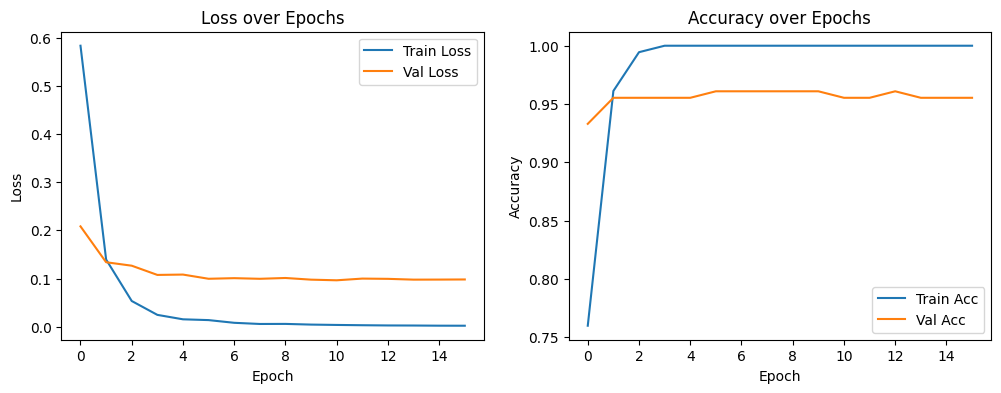


=== Final Test Set Evaluation ===
Test Accuracy: 92.18%
------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.89      0.93        64
           1       0.87      0.93      0.90        59
           2       0.93      0.95      0.94        56

    accuracy                           0.92       179
   macro avg       0.92      0.92      0.92       179
weighted avg       0.92      0.92      0.92       179



92.17877094972067

In [5]:
# ==========================================
# 5. VGG WITH NORMALIZATION
# ==========================================
print("\n--- 5. VGG with Image Normalization ---")

# 1. Transforms
vgg_weights = models.VGG16_Weights.IMAGENET1K_V1
vgg_transforms = vgg_weights.transforms()

# 2. Datasets
train_ds_norm = FlowerTensorDataset(X_train, y_train, transform=vgg_transforms)
val_ds_norm = FlowerTensorDataset(X_val, y_val, transform=vgg_transforms)
test_ds_norm = FlowerTensorDataset(X_test, y_test, transform=vgg_transforms)

train_loader_norm = DataLoader(train_ds_norm, batch_size=batch_size, shuffle=True)
val_loader_norm = DataLoader(val_ds_norm, batch_size=batch_size)
test_loader_norm = DataLoader(test_ds_norm, batch_size=batch_size)

# 3. Model
vgg_norm = models.vgg16(weights=vgg_weights)
for param in vgg_norm.features.parameters():
    param.requires_grad = False
vgg_norm.classifier = nn.Sequential(
    nn.Flatten(),
    nn.Linear(25088, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, num_classes)
)
vgg_norm = vgg_norm.to(device)
optimizer_norm = optim.Adam(vgg_norm.classifier.parameters(), lr=0.0001)

# 4. Train
# (Scheduler is active)
history_norm = train_network(vgg_norm, train_loader_norm, val_loader_norm, criterion, optimizer_norm, num_epochs=20, patience=5)

# 5. Plot & Test
plot_performance(history_norm)
evaluate_network(vgg_norm, test_loader_norm)


--- 6. Training with Data Augmentation ---
Starting training on mps...
Epoch [1/20] LR: 1.0e-04 | Train Loss: 0.6320 Acc: 0.7190 | Val Loss: 0.2465 Acc: 0.9106
Epoch [2/20] LR: 1.0e-04 | Train Loss: 0.2647 Acc: 0.8965 | Val Loss: 0.1518 Acc: 0.9553
Epoch [3/20] LR: 1.0e-04 | Train Loss: 0.1550 Acc: 0.9482 | Val Loss: 0.1552 Acc: 0.9330
Epoch [4/20] LR: 1.0e-04 | Train Loss: 0.0985 Acc: 0.9760 | Val Loss: 0.1312 Acc: 0.9441
Epoch [5/20] LR: 1.0e-04 | Train Loss: 0.0707 Acc: 0.9852 | Val Loss: 0.1422 Acc: 0.9385
Epoch [6/20] LR: 1.0e-04 | Train Loss: 0.0754 Acc: 0.9778 | Val Loss: 0.1331 Acc: 0.9441
Epoch [7/20] LR: 1.0e-04 | Train Loss: 0.0541 Acc: 0.9815 | Val Loss: 0.1443 Acc: 0.9441
Epoch [8/20] LR: 1.0e-05 | Train Loss: 0.0474 Acc: 0.9926 | Val Loss: 0.1431 Acc: 0.9441
Epoch [9/20] LR: 1.0e-05 | Train Loss: 0.0491 Acc: 0.9871 | Val Loss: 0.1341 Acc: 0.9441
Early stopping triggered at epoch 9
Restoring best weights with Val Loss: 0.1312


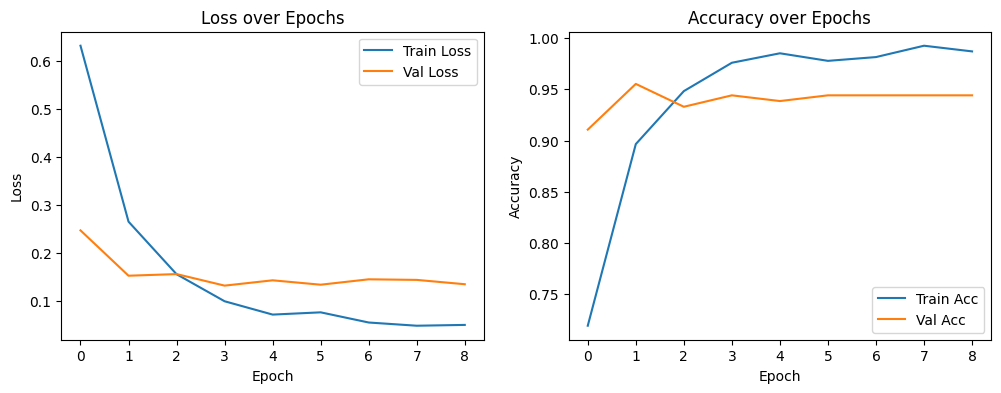


=== Final Test Set Evaluation ===
Test Accuracy: 91.06%
------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.89      0.90        64
           1       0.90      0.90      0.90        59
           2       0.93      0.95      0.94        56

    accuracy                           0.91       179
   macro avg       0.91      0.91      0.91       179
weighted avg       0.91      0.91      0.91       179



91.06145251396649

In [6]:
# ==========================================
# 6. DATA AUGMENTATION
# ==========================================
print("\n--- 6. Training with Data Augmentation ---")

# 1. Transforms
aug_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 2. Datasets
train_ds_aug = FlowerTensorDataset(X_train, y_train, transform=aug_transform)
# Note: Use normalized (non-augmented) loaders for Val and Test

train_loader_aug = DataLoader(train_ds_aug, batch_size=batch_size, shuffle=True)

# 3. Model
vgg_aug = models.vgg16(weights=vgg_weights)
for param in vgg_aug.features.parameters():
    param.requires_grad = False
vgg_aug.classifier = nn.Sequential(
    nn.Flatten(),
    nn.Linear(25088, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, num_classes)
)
vgg_aug = vgg_aug.to(device)
optimizer_aug = optim.Adam(vgg_aug.classifier.parameters(), lr=0.0001)

# 4. Train
# (Scheduler is active)
history_aug = train_network(vgg_aug, train_loader_aug, val_loader_norm, criterion, optimizer_aug, num_epochs=20, patience=5)

# 5. Plot & Test
plot_performance(history_aug)
evaluate_network(vgg_aug, test_loader_norm)


--- 7. Fine-Tuning: Training Last Conv Layer + Classifier ---
Unfreezing layer:  Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Total trainable parameters: 8783363
Using Augmented Training Data
Starting training on mps...
Epoch [1/20] LR: 1.0e-04 | Train Loss: 0.6100 Acc: 0.7542 | Val Loss: 0.2624 Acc: 0.8994
Epoch [2/20] LR: 1.0e-04 | Train Loss: 0.2005 Acc: 0.9261 | Val Loss: 0.1370 Acc: 0.9497
Epoch [3/20] LR: 1.0e-04 | Train Loss: 0.1036 Acc: 0.9649 | Val Loss: 0.1382 Acc: 0.9330
Epoch [4/20] LR: 1.0e-04 | Train Loss: 0.0817 Acc: 0.9723 | Val Loss: 0.1183 Acc: 0.9665
Epoch [5/20] LR: 1.0e-04 | Train Loss: 0.0436 Acc: 0.9889 | Val Loss: 0.1429 Acc: 0.9385
Epoch [6/20] LR: 1.0e-04 | Train Loss: 0.0309 Acc: 0.9945 | Val Loss: 0.1212 Acc: 0.9441
Epoch [7/20] LR: 1.0e-04 | Train Loss: 0.0229 Acc: 0.9963 | Val Loss: 0.1400 Acc: 0.9441
Epoch [8/20] LR: 1.0e-05 | Train Loss: 0.0157 Acc: 0.9982 | Val Loss: 0.1328 Acc: 0.9441
Epoch [9/20] LR: 1.0e-05 | Train Loss: 0.016

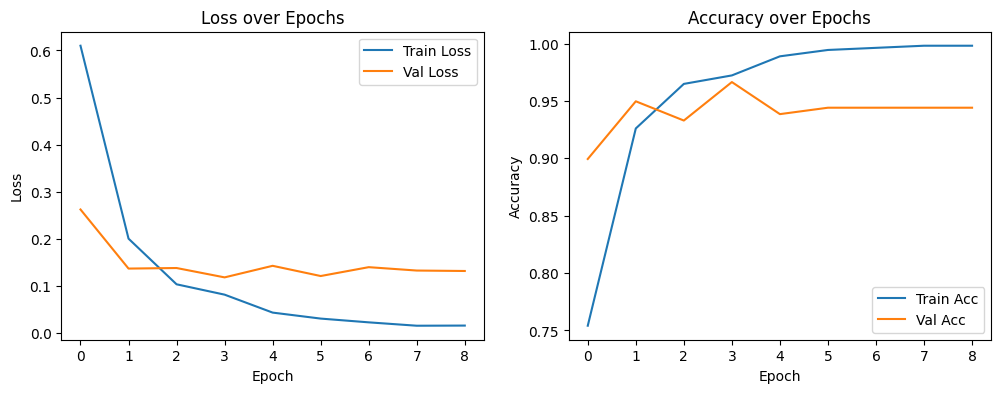


=== Final Test Set Evaluation ===
Test Accuracy: 91.62%
------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.92      0.91        64
           1       0.90      0.92      0.91        59
           2       0.96      0.91      0.94        56

    accuracy                           0.92       179
   macro avg       0.92      0.92      0.92       179
weighted avg       0.92      0.92      0.92       179



91.62011173184358

In [7]:
# ==========================================
# 7. FINE-TUNING (Train Last Conv Layer + Classifier)
# ==========================================
print("\n--- 7. Fine-Tuning: Training Last Conv Layer + Classifier ---")

# 1. Load Pretrained Weights
vgg_weights = models.VGG16_Weights.IMAGENET1K_V1
vgg_fine = models.vgg16(weights=vgg_weights)

# 2. FREEZE ALL layers first
for param in vgg_fine.features.parameters():
    param.requires_grad = False

# 3. UNFREEZE the Last Convolutional Layer
# In standard VGG16, features are indexed 0 to 30.
# The last Conv2d layer is at index 28.
# We unfreeze its weights and bias.
print("Unfreezing layer: ", vgg_fine.features[28])
for param in vgg_fine.features[28].parameters():
    param.requires_grad = True

# 4. Custom Classifier (Trainable)
num_features = vgg_fine.classifier[0].in_features
vgg_fine.classifier = nn.Sequential(
    nn.Flatten(),
    nn.Linear(num_features, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, num_classes)
)

vgg_fine = vgg_fine.to(device)

# 5. Verify Trainable Parameters
# We filter the optimizer to only update parameters that have requires_grad=True
trainable_params = filter(lambda p: p.requires_grad, vgg_fine.parameters())
params_to_update = sum(p.numel() for p in vgg_fine.parameters() if p.requires_grad)
print(f"Total trainable parameters: {params_to_update}")

# 6. Optimizer
# Note: We often use a lower learning rate (e.g., 1e-5) when fine-tuning conv layers 
# to avoid destroying the pre-trained weights, but 1e-4 is okay for this exercise.
optimizer_fine = optim.Adam(filter(lambda p: p.requires_grad, vgg_fine.parameters()), lr=0.0001)

# 7. Train
# We typically reuse the Augmented Data Loader (train_loader_aug) from Section 6
# to prevent overfitting since the model is now more complex/flexible.
if 'train_loader_aug' in locals():
    print("Using Augmented Training Data")
    loader_to_use = train_loader_aug
else:
    print("Augmented loader not found, falling back to standard loader")
    loader_to_use = train_loader

history_fine = train_network(vgg_fine, loader_to_use, val_loader_norm, criterion, optimizer_fine, num_epochs=20, patience=5)

# 8. Plot & Test
plot_performance(history_fine)
evaluate_network(vgg_fine, test_loader_norm)